### 1. Import libraries necessary

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger

### 2. Design dataset

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): 根目錄(path/to/Test or path/to/Train)
            transform (callable, optional): 資料增強與轉換
        """
        self.image_paths = []
        self.labels = []
        self.label_map = {
            "glioma": 0,
            "meningioma": 1,
            "notumor": 2,
            "pituitary": 3
        }
        self.transform = transform

        # 讀取資料夾
        for label_name, label_idx in self.label_map.items():
            class_dir = os.path.join(root_dir, label_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### 3. Design model (Linear classifier, didn't freeze weight)

In [3]:
# Lightning 模型
class BrainTumorClassifier(pl.LightningModule):
    def __init__(self, num_classes=4, lr=1e-4):
        super(BrainTumorClassifier, self).__init__()
        self.save_hyperparameters()
        # 載入預訓練的 MobileNetV3 並修改輸出層
        self.model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)
        print("loss = ", loss)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)

        acc = (preds.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)

        acc = (preds.argmax(dim=1) == labels).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### 4. Define trainer, data loader and transform

In [4]:
# 資料增強與轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 資料路徑
train_dir = "./Training"
test_dir = "./Testing"

# 初始化 Dataset 和 DataLoader
train_dataset = BrainTumorDataset(train_dir, transform=transform)
test_dataset = BrainTumorDataset(test_dir, transform=transform)

### 5. Training

In [6]:
# 重複5次訓練
for run in range(5):
    print(f"Run {run + 1}")

    # 初始化 K-Fold，使用不同的random state
    kf = KFold(n_splits=5, shuffle=True, random_state=run*42)

    # 每個 run 重新初始化 Lightning 模型
    model = BrainTumorClassifier(num_classes=4)

    # 初始化 ModelCheckpoint 回調函數(每個 run 只跑一次)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename=f"unfreezed-run{run+1:01d}-{{val_loss:.2f}}-{{val_acc:.2f}}",
    )

    # 初始化 TensorBoard logger
    logger = TensorBoardLogger("tb_logs", name=f"unfreezed-run_{run+1}")

    # 進行 5-Fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}")
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize Trainer
        trainer = pl.Trainer(
            max_epochs=6,
            accelerator="gpu" if torch.cuda.is_available() else "cpu",  # 啟用 GPU（如果可用）
            devices="auto",
            precision="16-mixed" if torch.cuda.is_available() else 32,  # 使用 16-bit 淺精度加速
            # log_every_n_steps=10,
            val_check_interval=1.0,
            logger=logger,
            callbacks=[
                checkpoint_callback,
            ]
        )

        # 開始訓練
        trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True


Run 1
Fold 1


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.0162, val_loss=0.0853, val_acc=0.970]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.0162, val_loss=0.0853, val_acc=0.970]


Using 16bit Automatic Mixed Precision (AMP)


Fold 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\Python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory tb_logs\unfreezed-run_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s, v_num=0, train_loss=0.000154, val_loss=0.00692, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s, v_num=0, train_loss=0.000154, val_loss=0.00692, val_acc=0.998]

Using 16bit Automatic Mixed Precision (AMP)



Fold 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00718, val_loss=0.00622, val_acc=0.999]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00718, val_loss=0.00622, val_acc=0.999]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode



Fold 4
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=6.78e-6, val_loss=0.00747, val_acc=0.999]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=6.78e-6, val_loss=0.00747, val_acc=0.999]

Using 16bit Automatic Mixed Precision (AMP)



Fold 5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s, v_num=0, train_loss=5.96e-5, val_loss=0.000436, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s, v_num=0, train_loss=5.96e-5, val_loss=0.000436, val_acc=1.000]
Run 2


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Fold 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.00372, val_loss=0.0808, val_acc=0.975]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.00372, val_loss=0.0808, val_acc=0.975]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True



Fold 2


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\Python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory tb_logs\unfreezed-run_2\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=3.12e-5, val_loss=0.00444, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=3.12e-5, val_loss=0.00444, val_acc=0.998]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode



Fold 3
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s, v_num=0, train_loss=0.000286, val_loss=0.00186, val_acc=0.999] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s, v_num=0, train_loss=0.000286, val_loss=0.00186, val_acc=0.999]


Using 16bit Automatic Mixed Precision (AMP)


Fold 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.38it/s, v_num=0, train_loss=3.32e-5, val_loss=0.000156, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.36it/s, v_num=0, train_loss=3.32e-5, val_loss=0.000156, val_acc=1.000]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode



Fold 5
Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s, v_num=0, train_loss=1.91e-6, val_loss=0.00107, val_acc=0.999]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s, v_num=0, train_loss=1.91e-6, val_loss=0.00107, val_acc=0.999]
Run 3


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Fold 1
Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s, v_num=0, train_loss=0.00924, val_loss=0.0458, val_acc=0.985]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.37it/s, v_num=0, train_loss=0.00924, val_loss=0.0458, val_acc=0.985]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\Python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory tb_logs\unfreezed-run_3\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode



Fold 2
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s, v_num=0, train_loss=0.0785, val_loss=0.0114, val_acc=0.997]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s, v_num=0, train_loss=0.0785, val_loss=0.0114, val_acc=0.997]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Fold 3
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0441, val_loss=0.0063, val_acc=0.997]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0441, val_loss=0.0063, val_acc=0.997]


Using 16bit Automatic Mixed Precision (AMP)


Fold 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s, v_num=0, train_loss=1.98e-6, val_loss=0.000125, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=1.98e-6, val_loss=0.000125, val_acc=1.000]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True



Fold 5


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00709, val_loss=0.000148, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00709, val_loss=0.000148, val_acc=1.000]
Run 4


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Fold 1
Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00086, val_loss=0.118, val_acc=0.968]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.00086, val_loss=0.118, val_acc=0.968]
Fold 2


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\Python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory tb_logs\unfreezed-run_4\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0285, val_loss=0.00388, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0285, val_loss=0.00388, val_acc=0.998]


Using 16bit Automatic Mixed Precision (AMP)


Fold 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.38it/s, v_num=0, train_loss=0.000366, val_loss=0.000948, val_acc=0.999]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.38it/s, v_num=0, train_loss=0.000366, val_loss=0.000948, val_acc=0.999]

Using 16bit Automatic Mixed Precision (AMP)



Fold 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0171, val_loss=0.0198, val_acc=0.992] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.0171, val_loss=0.0198, val_acc=0.992]


Using 16bit Automatic Mixed Precision (AMP)


Fold 5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.000158, val_loss=0.00122, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.000158, val_loss=0.00122, val_acc=1.000]
Run 5


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1



  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.019, val_loss=0.089, val_acc=0.976] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.38it/s, v_num=0, train_loss=0.019, val_loss=0.089, val_acc=0.976]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\Python\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory tb_logs\unfreezed-run_5\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode



Fold 2
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.000808, val_loss=0.00367, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s, v_num=0, train_loss=0.000808, val_loss=0.00367, val_acc=0.998]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Fold 3
Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.0682, val_loss=0.0012, val_acc=1.000]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s, v_num=0, train_loss=0.0682, val_loss=0.0012, val_acc=1.000]

Using 16bit Automatic Mixed Precision (AMP)



Fold 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.0414, val_loss=0.00853, val_acc=0.998]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.0414, val_loss=0.00853, val_acc=0.998]


Using 16bit Automatic Mixed Precision (AMP)


Fold 5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MobileNetV3      | 4.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.829    Total estimated model params size (MB)
256       Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.000168, val_loss=0.0146, val_acc=0.995]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s, v_num=0, train_loss=0.000168, val_loss=0.0146, val_acc=0.995]


### 6. Testing

Testing checkpoint: tb_logs\unfreezed-run_1\version_0\checkpoints\unfreezed-run1-val_loss=0.00-val_acc=1.00.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9938977956771851     │
│         test_loss         │    0.03689337894320488    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03689337894320488, 'test_acc': 0.9938977956771851}]


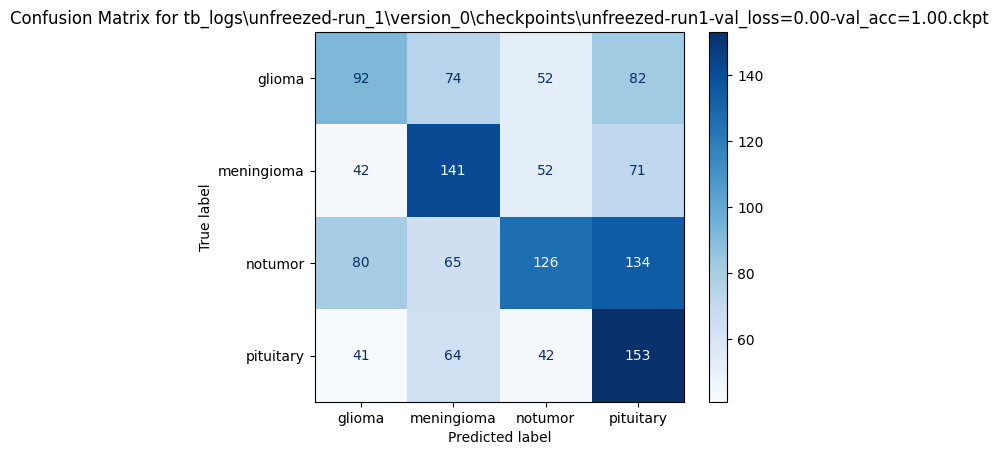

Testing checkpoint: tb_logs\unfreezed-run_2\version_0\checkpoints\unfreezed-run2-val_loss=0.00-val_acc=1.00.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 41/41 [00:04<00:00,  9.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9923722147941589     │
│         test_loss         │   0.021103641018271446    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.021103641018271446, 'test_acc': 0.9923722147941589}]


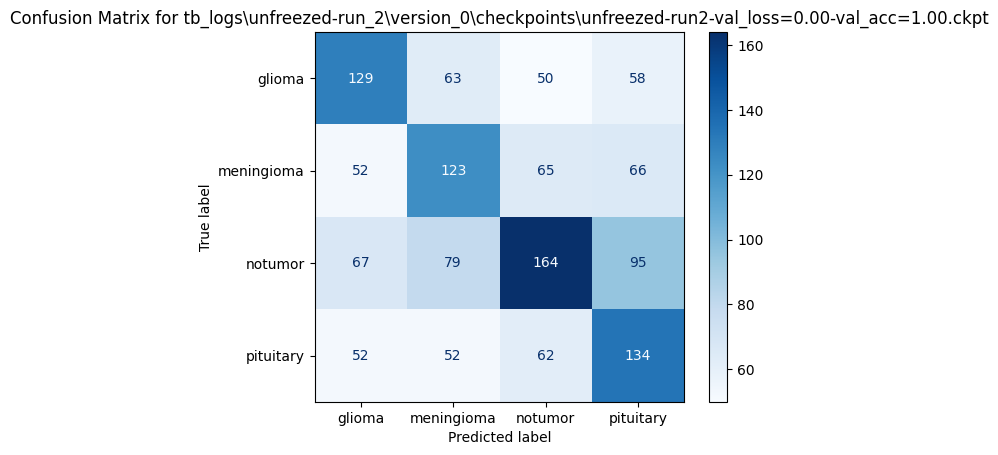

Testing checkpoint: tb_logs\unfreezed-run_3\version_0\checkpoints\unfreezed-run3-val_loss=0.00-val_acc=1.00.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 41/41 [00:04<00:00,  9.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9961861371994019     │
│         test_loss         │    0.01659381575882435    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.01659381575882435, 'test_acc': 0.9961861371994019}]


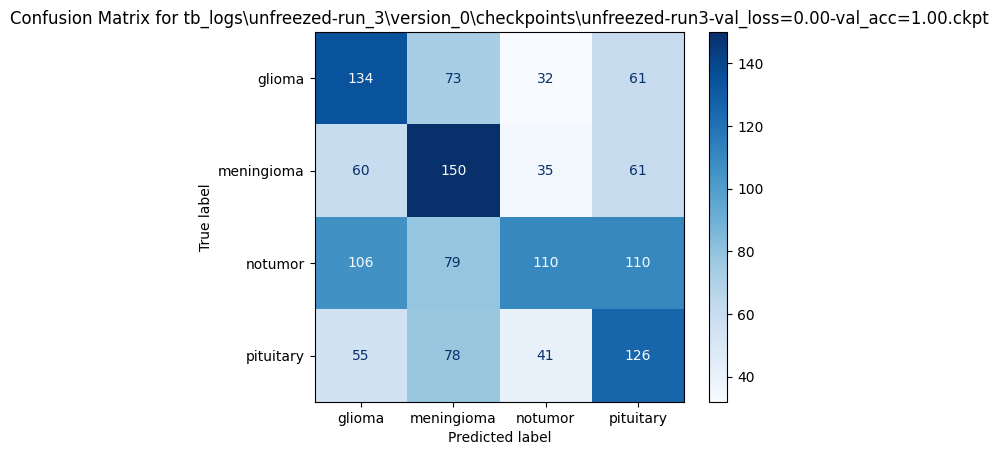

Testing checkpoint: tb_logs\unfreezed-run_4\version_0\checkpoints\unfreezed-run4-val_loss=0.00-val_acc=1.00.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 41/41 [00:04<00:00,  9.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9870327711105347     │
│         test_loss         │   0.056353241205215454    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.056353241205215454, 'test_acc': 0.9870327711105347}]


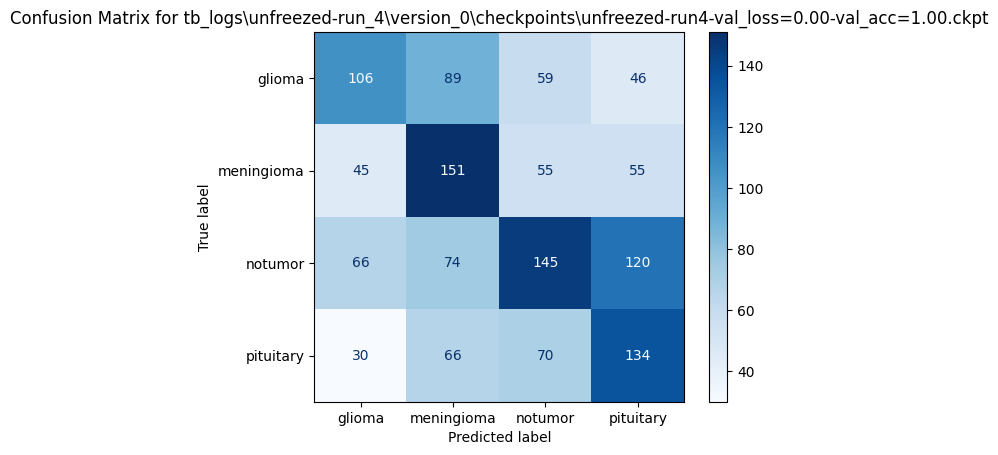

Testing checkpoint: tb_logs\unfreezed-run_5\version_0\checkpoints\unfreezed-run5-val_loss=0.00-val_acc=1.00.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 41/41 [00:04<00:00,  9.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9900839328765869     │
│         test_loss         │   0.022411828860640526    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.022411828860640526, 'test_acc': 0.9900839328765869}]


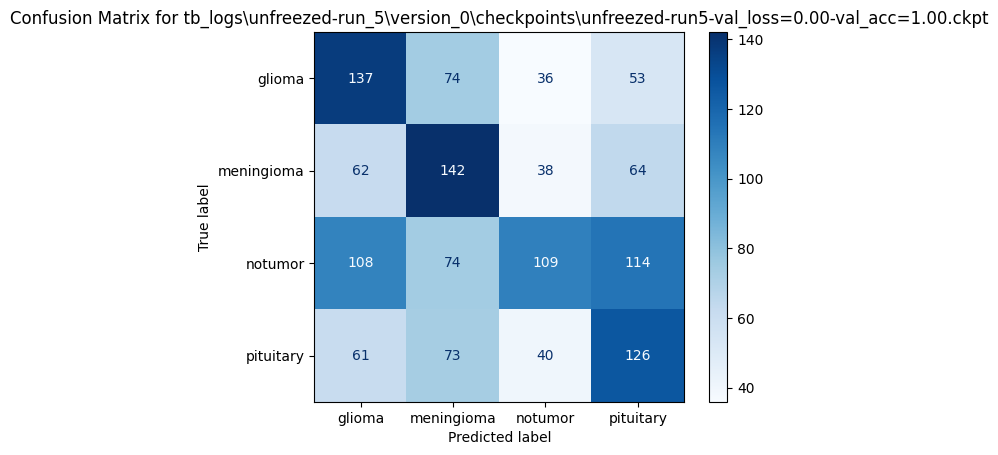

In [8]:
# 測試所有 checkpoint
def test_all_checkpoints(checkpoint_dirs, test_loader):
    for checkpoint_dir in checkpoint_dirs:
        checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))
        for checkpoint_file in checkpoint_files:
            print(f"Testing checkpoint: {checkpoint_file}")
            model = BrainTumorClassifier.load_from_checkpoint(checkpoint_file)
            trainer = pl.Trainer(logger=False)
            results = trainer.test(model, test_loader)
            print(results)
            
            # 計算混淆矩陣
            all_preds = []
            all_labels = []
            for batch in test_loader:
                images, labels = batch
                preds = model(images).argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            cm = confusion_matrix(all_labels, all_preds)
            
            # 繪製混淆矩陣
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "notumor", "pituitary"])
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix for {checkpoint_file}")
            plt.show()

# 假設 test_loader 已經定義
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

checkpoint_dirs = glob.glob("tb_logs/unfreezed-run_*/version_*/checkpoints")
test_all_checkpoints(checkpoint_dirs, test_loader)